In [5]:
import tensorflow as tf
import numpy as np

class MAML(tf.keras.Model):
    def __init__(self, input_shape, num_classes, inner_lr=0.01, outer_lr=0.001):
        super(MAML, self).__init__()
        self.inner_lr = inner_lr
        self.outer_optimizer = tf.keras.optimizers.Adam(learning_rate=outer_lr)
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        # Define a simple MLP model as an example (can be replaced with CNN)
        self.base_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=input_shape),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_classes)
        ])

    def clone_model_with_weights(self):
        cloned_model = tf.keras.models.clone_model(self.base_model)
        cloned_model.set_weights(self.base_model.get_weights())
        return cloned_model

    def adapt(self, model, x_train, y_train):
        with tf.GradientTape() as tape:
            logits = model(x_train, training=True)
            loss = self.loss_fn(y_train, logits)
        grads = tape.gradient(loss, model.trainable_variables)
        k = 0
        for var in model.trainable_variables:
            var.assign_sub(self.inner_lr * grads[k])
            k += 1
        return model

    def train_step(self, support_set, query_set):
        x_support, y_support = support_set
        x_query, y_query = query_set

        cloned_model = self.clone_model_with_weights()
        adapted_model = self.adapt(cloned_model, x_support, y_support)

        with tf.GradientTape() as tape:
            logits = adapted_model(x_query, training=True)
            loss = self.loss_fn(y_query, logits)
        #grads = tape.gradient(loss, self.base_model.trainable_variables)
        grads = [(a - b) / self.inner_lr for a, b in zip(self.base_model.trainable_variables, adapted_model.trainable_variables)]

        self.outer_optimizer.apply_gradients(zip(grads, self.base_model.trainable_variables))

        acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, axis=1), y_query), tf.float32))
        return loss, acc

    def evaluate(self, x, y):
        logits = self.base_model(x)
        pred = tf.argmax(logits, axis=1)
        acc = tf.reduce_mean(tf.cast(tf.equal(pred, y), tf.float32))
        return acc.numpy()

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
#from maml_few_shot import MAML  # assumes MAML is implemented as shown earlier
import utils
import config


class MAMLProgressiveTrainer:
    def __init__(self, config):
        self.default_path = config.default_path
        self.classes = config.classes
        self.dataset = config.dataset
        self.info = config.Info
        self.train_ratio = 0.5
        self.inner_epochs = 1
        self.outer_epochs = 50
        self.shot = 5
        self.query_size = 5

        self.trained_acc_all = []
        self.prev_acc_all = []
        self.init_acc_all = []

        self.X_test_prev_all = []
        self.y_test_prev_all = []


    def prepare_episode(self, X, y, n_shot, n_query):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]
        return (X[:n_shot].astype(np.float32), y[:n_shot]), (X[n_shot:n_shot+n_query].astype(np.float32), y[n_shot:n_shot+n_query])


    def run(self):
        for idx, session in enumerate(self.dataset):
            print(f"\n{'='*43}\nDataset {idx+1}/{len(self.dataset)} - Session {session}\n{'='*43}")
            path = os.path.join(self.default_path, session + 'raw/')
            feature_set, labels = utils.get_dataset(path, self.classes, show_labels=False)
            X_train, y_train, X_test, y_test = utils.split_data(feature_set, labels, ratio=self.train_ratio)

            if idx == 0:
                input_shape = X_train.shape[1:]
                num_classes = len(np.unique(y_train))
                self.maml = MAML(input_shape=input_shape, num_classes=num_classes)

                support, query = self.prepare_episode(X_train, y_train, self.shot, self.query_size)

                for epoch in range(self.outer_epochs):
                    loss, acc = self.maml.train_step(support, query)
                    if epoch % 10 == 0:
                        print(f"Epoch {epoch+1}: Loss={loss:.4f}, Acc={acc:.4f}")

                acc = self.maml.evaluate(X_test, y_test)
                self.init_acc_all.append(0.2)
                self.trained_acc_all.append(acc)
                self.prev_acc_all.append(acc)
                self.X_test_prev_all = X_test
                self.y_test_prev_all = y_test
            else:
                support, query = self.prepare_episode(X_train, y_train, self.shot, self.query_size)

                for epoch in range(self.outer_epochs):
                    loss, acc = self.maml.train_step(support, query)

                acc_curr = self.maml.evaluate(X_test, y_test)
                X_combined = np.concatenate((self.X_test_prev_all, X_test), axis=0)
                y_combined = np.concatenate((self.y_test_prev_all, y_test), axis=0)
                acc_prev = self.maml.evaluate(X_combined, y_combined)

                self.init_acc_all.append(0.2)
                self.trained_acc_all.append(acc_curr)
                self.prev_acc_all.append(acc_prev)
                self.X_test_prev_all = X_combined
                self.y_test_prev_all = y_combined

        return self.init_acc_all, self.trained_acc_all, self.prev_acc_all

    def plot_results(self, baselines, baseline_K):

        plt.figure(figsize=(15, 8))
        plt.title('Training from scratch every time', fontsize=15)
        plt.plot(self.info, self.init_acc_all, marker='o', label='Untrained model on current data', linestyle='--')
        plt.plot(self.info, self.prev_acc_all, marker='o', label='Model trained + tested on accumulated data')
        plt.plot(self.info, self.trained_acc_all, marker='o', label='Model trained + tested on current split')

        for idx, base in enumerate(baselines):
            baseline_result = pd.read_csv(base)
            plt.plot(self.info, baseline_result['Accuracy'] / 100, marker='^', label=f'Baseline V{idx} - K:{baseline_K[idx]}', linestyle='--')

        plt.ylim([0, 1])
        plt.xlabel('Date (Sessions)')
        plt.ylabel('Test Accuracy')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Dataset 1/26 - Session Exp_2025-05-27/E8331D05289A/
Epoch 1: Loss=1.5231, Acc=0.6000
Epoch 11: Loss=0.3022, Acc=1.0000
Epoch 21: Loss=0.0694, Acc=1.0000
Epoch 31: Loss=0.0215, Acc=1.0000
Epoch 41: Loss=0.0119, Acc=1.0000

Dataset 2/26 - Session Exp_2025-06-18/E9AD0E7DCC2B/

Dataset 3/26 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/

Dataset 4/26 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/

Dataset 5/26 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/

Dataset 6/26 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/

Dataset 7/26 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/

Dataset 8/26 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/

Dataset 9/26 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/

Dataset 10/26 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/

Dataset 11/26 - Session Exp_2025-06-23-v1/E9AD0E7DCC2B/

Dataset 12/26 - Session Exp_2025-06-23-v2/E9AD0E7DCC2B/

Dataset 13/26 - Session Exp_2025-06-23-v3/E9AD0E7DCC2B/

Dataset 14/26 - Session Exp_2025-06-23-v4/E9AD0E7DCC2B/

Dataset 15/26 - Session Exp_2025-06-24-v1/E9AD0

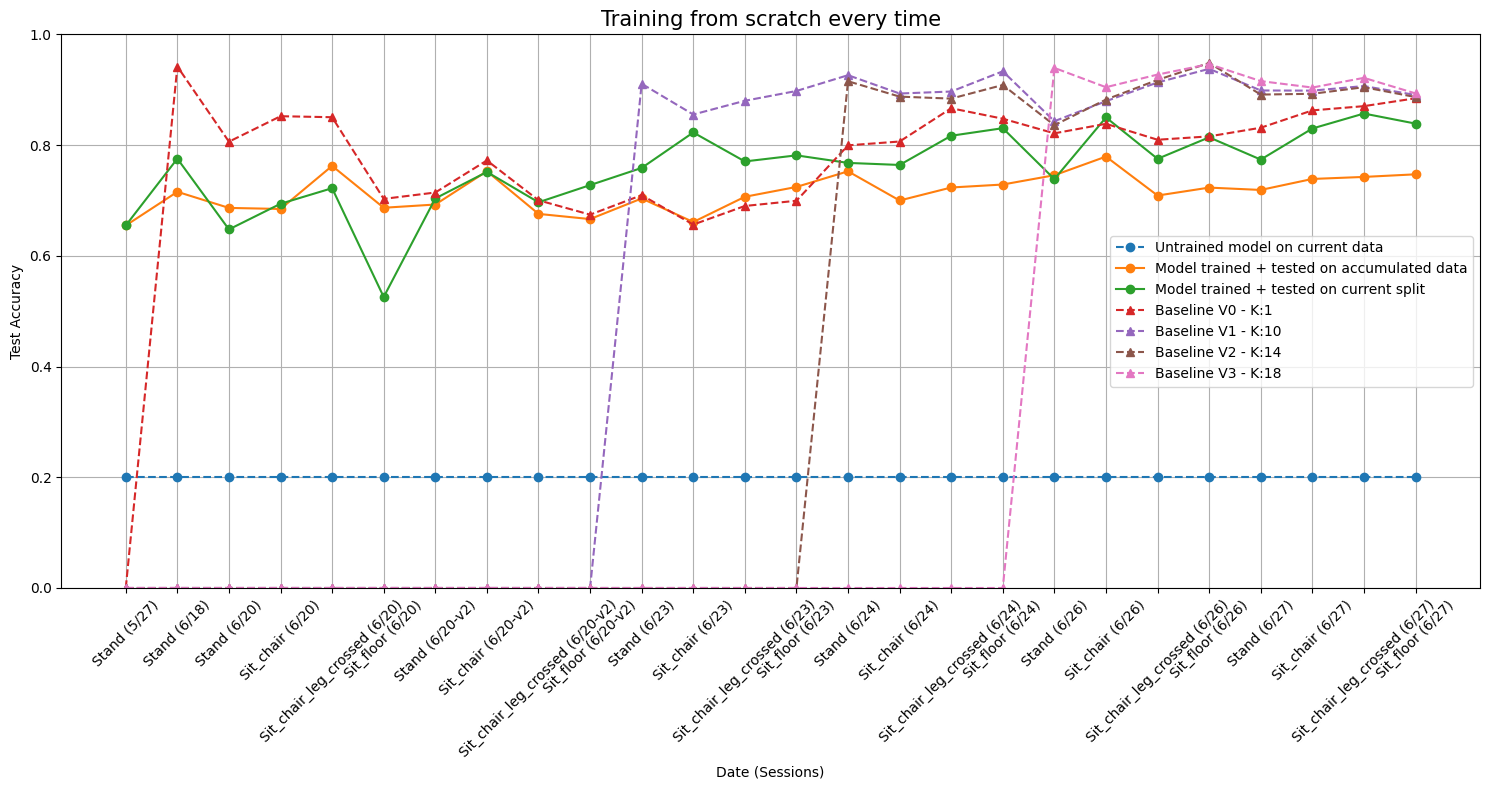

Average of acc without training anything (should be random): 20.00%
Average of acc using previous test data after training: 75.72%
Average of acc using current test data after training: 71.47%


In [7]:
#baseline1_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results.csv'
baseline1_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results_train_with_1data.csv'
baseline2_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results_train_with_10data.csv'
baseline3_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results_train_with_14data.csv'
baseline4_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results_train_with_18data.csv'
baselines = [baseline1_csv_path, baseline2_csv_path,  baseline3_csv_path,  baseline4_csv_path]
baseline_K = ['1', '10', '14', '18']

trainer = MAMLProgressiveTrainer(config)
Init_acc_all, Prev_acc_all, Trained_acc_all = trainer.run()
trainer.plot_results(baselines, baseline_K)

for idx, x in enumerate([Init_acc_all, Prev_acc_all, Trained_acc_all]):
    if idx==0:
        print(f"Average of acc without training anything (should be random): {np.mean(x)*100:.2f}%")
    elif idx==1:
        print(f"Average of acc using previous test data after training: {np.mean(x)*100:.2f}%")
    elif idx==2:
        print(f"Average of acc using current test data after training: {np.mean(x)*100:.2f}%")